In [175]:
%matplotlib inline
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

In [176]:
def save_for_bladerf(filename, signal):
    interleaved = np.empty(2*len(signal))
    interleaved[0::2] = np.real(signal)
    interleaved[1::2] = np.imag(signal)
    if any(np.abs(interleaved) > 1.0):
        print('Some samples are larger than 1.0, clipping will occur')
        interleaved = np.max(-1.0, interleaved)
        interleaved = np.min(1.0, interleaved)
    quantized = (interleaved * 2047).astype(np.int16)
    with file(filename, 'wb') as fid:
        quantized.tofile(fid)

In [177]:
def load_from_bladerf(filename):
    quantized = np.fromfile(filename, dtype=np.int16)
    interleaved = quantized.astype(np.float) / 2047.
    cmplx = interleaved[0::2] + 1j*interleaved[1::2]
    return cmplx

Verification of synchronized BladeRF transmission
===

In this notebook I describe a method to verify the synchronity of multiple BladeRF units using the trigger mechanism over mini_exp1.

Idea
---

The basic idea is to run two BladeRF in full duplex mode and synchronized. Both transmitters start sending at the same time and on the same frequency but each signal can be easily located in the mixture by means of correlation (similar to what GPS does). If both transmit signals are found at the same position in the mix, that means that the transmitters are synchronized. If the positions there the transmit signals are found are the same for both receivers, that means the receivers are synchronized.

Transmit Signal
---

Each transmitter sends a complex pseudo-random sequence. Those usually have a very narrow autocorrelation peak and virtually no cross-correlation which makes them very easy to locate in the resulting signal mixture.

The example used here is two QPSK data streams with random data. Each stream is oversampled by a factor of four and pulse-shaped with a RRC-type filter.

In [178]:
# Load RRC Pulse (4x Oversampling)
pulse = np.load('pulse.npy')

# Generate two complex pseudorandom sequences
siglen = 5000
cpr1 = 0.5 * (np.sign(np.random.randn(siglen)) + 1j*np.sign(np.random.randn(siglen)))
cpr2 = 0.5 * (np.sign(np.random.randn(siglen)) + 1j*np.sign(np.random.randn(siglen)))

# Tx upsampling and pulse shaping
tx1 = np.zeros(4*cpr1.shape[0], dtype=np.complex)
tx2 = np.zeros(4*cpr2.shape[0], dtype=np.complex)
tx1[0::4] = cpr1
tx2[0::4] = cpr2

tx1 = sig.convolve(tx1, pulse)
tx2 = sig.convolve(tx2, pulse)

In [179]:
# There is a single high autocorrelation peak and essentially zero cross-correlation between the signals
ac1 = sig.correlate(tx1, tx1)
ac2 = sig.correlate(tx2, tx2)
cc = sig.correlate(tx1, tx2)

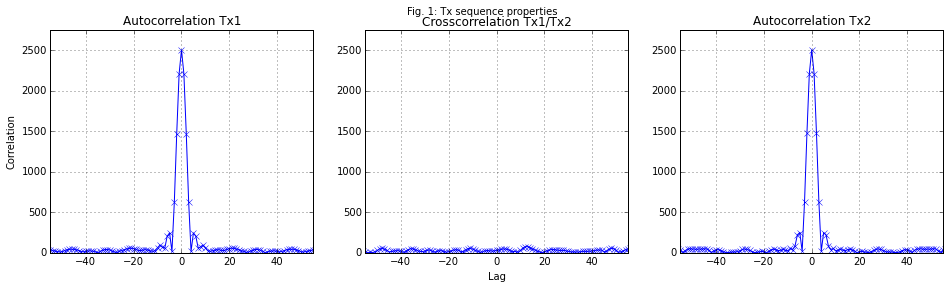

In [234]:
f = plt.figure(figsize=(16, 4))
lags = np.arange(ac1.shape[0]) - (ac1.shape[0]-1) / 2
peak = np.max((np.abs(ac1), np.abs(ac2), np.abs(cc)))

plt.subplot(131)
plt.plot(lags, np.abs(ac1), 'bx-')
plt.ylabel('Correlation')
plt.title('Autocorrelation Tx1')
plt.xlim((-55, 55))
plt.ylim((0, 1.1*peak))
plt.grid(True)

plt.subplot(132)
plt.plot(lags, np.abs(cc), 'bx-')
plt.xlabel('Lag')
plt.title('Crosscorrelation Tx1/Tx2')
plt.xlim((-55, 55))
plt.ylim((0, 1.1*peak))
plt.grid(True)

plt.subplot(133)
plt.plot(lags, np.abs(ac2), 'bx-')
plt.title('Autocorrelation Tx2')
plt.xlim((-55, 55))
plt.ylim((0, 1.1*peak))
plt.grid(True)

plt.suptitle('Fig. 1: Tx sequence properties')

In [186]:
# Prepend some zero-samples since the first few received samples are usually garbage
zerolen = 5000
pad_tx1 = np.concatenate((np.zeros(zerolen), tx1))
pad_tx2 = np.concatenate((np.zeros(zerolen), tx2))
# Save signals for later transmission from bladeRF-cli
save_for_bladerf('tx1.dat', pad_tx1)
save_for_bladerf('tx2.dat', pad_tx2)

It can be seen that the pulse has the desired properties. Cross-correlating the received sum-signal with the transmit signals should locate each one separately in the mixture.

Physical setup
---

 * Both BladeRF units share a clock via the SMB CLK connector.
 * The mini_exp1 pins are connected with a jumper wire
 * The ground pins are connected with a jumper wire
 * Both BladeRF have antennas on Tx and Rx SMA ports
 * Alternatively use an RF combiner to sum the Tx signals and connect them to the receivers with an RF splitter
 
Data transmission
---

Upload the trigger-enabled FPGA image to both BladeRF and open one `bladeRF-cli` instance for each unit in interactive mode. Since typing the commands in the console will take some time, it is highly recommended that you disable USB timeouts while trying this out or your `tx` and `rx` commands will timeout after one second. Hence, you want to set a big timeout for each operation.

 * First of all configure a shared clock between the bladeRF<br>
   _On console 1_
        bladeRF> mimo master
          Successfully set device to master MIMO mode.
   _On console 2_
        bladeRF> mimo slave
          Successfully set device to slave MIMO mode.
 * Configure general transmission parameters. I transmit at 2.45 GHz and 20 MHz samplerate. I was using a cabled setup so your gain values probably need to be higher.<br>
   _On both consoles_
        bladeRF> set bandwidth 20000000
          Set RX bandwidth - req: 20000000Hz actual: 20000000Hz
          Set TX bandwidth - req: 20000000Hz actual: 20000000Hz
        bladeRF> set samplerate 20000000
          Setting RX sample rate - req:  20000000 0/1Hz, actual:  20000000 0/1Hz
          Setting TX sample rate - req:  20000000 0/1Hz, actual:  20000000 0/1Hz
        bladeRF> set frequency 2450000000
          Set RX frequency: 2449999999Hz
          Set TX frequency: 2449999999Hz
        bladeRF> set txvga1 -20
        bladeRF> set txvga2 3
        bladeRF> set rxvga1 20
        bladeRF> set rxvga2 22
        bladeRF> set lnagain 6
 * Configure Tx/Rx, mind the large timeout<br>
   _On console 1_
        bladeRF> tx config format=bin repeat=1 timeout=60000 file=tx1.dat
        bladeRF> rx config n=30000 format=bin timeout=60000 file=rx1.dat
   _On console 2_
        bladeRF> tx config format=bin repeat=1 timeout=60000 file=tx2.dat
        bladeRF> rx config n=30000 format=bin timeout=60000 file=rx2.dat
 * Configure master trigger, I selected the Tx module of the first bladeRF<br>
   _On console 1_
        bladeRF> trigger tx master
          TX-trigger successfully configured as master
 * Configure all other triggers as slaves<br>
   _On console 1_
        bladeRF> trigger rx slave
          RX-trigger successfully configured as slave
   _On console 2_
        bladeRF> trigger tx slave
          TX-trigger successfully configured as slave
        bladeRF> trigger rx slave
          RX-trigger successfully configured as slave
 * You can verify the trigger configuration now, it should look like this<br>
   _On console 1_
        bladeRF> trigger
          TX-trigger register value: 0x05
           |- Trigger system is enabled
           |- Trigger configured as master
           |- Fire request is not set
           |- mini_exp1 line LOW, trigger NOT FIRED
          RX-trigger register value: 0x01
           |- Trigger system is enabled
           |- Trigger configured as slave
           |- mini_exp1 line LOW, trigger NOT FIRED
   _On console 2_
        bladeRF> trigger
          TX-trigger register value: 0x01
           |- Trigger system is enabled
           |- Trigger configured as slave
           |- mini_exp1 line LOW, trigger NOT FIRED
          RX-trigger register value: 0x01
           |- Trigger system is enabled
           |- Trigger configured as slave
           |- mini_exp1 line LOW, trigger NOT FIRED
 * Start the transmission<br>
   _On both consoles_
        bladeRF> tx start
        bladeRF> rx start
 * Normally, the 25000 samples would be transmitted after 1.25 ms, checking the tx or rx state on either radio reveals that the task is still running. This indicates that the trigger prevents transmission or reception until it fires.<br>
   _On both consoles_
        bladeRF> tx
          State: Running
          [...]
        bladeRF> rx
          State: Running
          [...]
 * Fire the trigger<br>
   _On console 1_
        bladeRF> trigger tx fire
          Successfully set fire-request on TX-trigger
 * Checking the status again, the tasks are finished<br>
   _On both consoles_
        bladeRF> tx
          State: Idle
          [...]
        bladeRF> rx
          State: Idle
          [...]
 * Finally, disable the trigger after everything is done<br>
   _On console 1_
        bladeRF> trigger tx stop
          Successfully cleared fire-request on TX-trigger
          
Results
---

Time to analyze the results. The received signals will be cross-correlated with each transmit signal to find their position in the received stream. If all radios are synchronized we expect to find both transmit signals in the same place of both received signals.

In [223]:
rx1 = load_from_bladerf('rx1.dat')[zerolen:]
rx2 = load_from_bladerf('rx2.dat')[zerolen:]

In [224]:
r1t1 = np.abs(sig.correlate(rx1, tx1, 'valid'))
r1t2 = np.abs(sig.correlate(rx1, tx2, 'valid'))
r2t1 = np.abs(sig.correlate(rx2, tx1, 'valid'))
r2t2 = np.abs(sig.correlate(rx2, tx2, 'valid'))

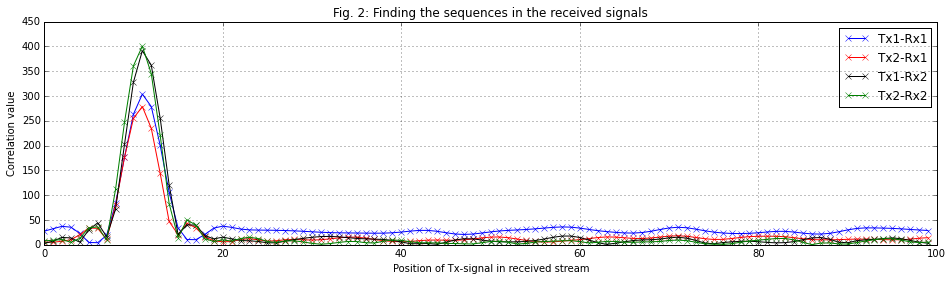

In [232]:
plt.figure(figsize=(16, 4))
plt.plot(r1t1[:100], 'bx-')
plt.plot(r1t2[:100], 'rx-')
plt.plot(r2t1[:100], 'kx-')
plt.plot(r2t2[:100], 'gx-')
plt.grid(True)
plt.xlabel('Position of Tx-signal in received stream')
plt.ylabel('Correlation value')
plt.legend(('Tx1-Rx1', 'Tx2-Rx1', 'Tx1-Rx2', 'Tx2-Rx2'))
plt.title('Fig. 2: Finding the sequences in the received signals');

In [226]:
peak_r1t1 = np.argmax(r1t1)
peak_r1t2 = np.argmax(r1t2)
peak_r2t1 = np.argmax(r2t1)
peak_r2t2 = np.argmax(r2t2)

diff_tx = peak_r1t2 - peak_r1t1
diff_rx = peak_r2t1 - peak_r1t1

print('Tx1 received from Rx1 at offset %i' % (peak_r1t1))
print('Tx2 received from Rx1 at offset %i' % (peak_r1t2))
print('Tx1 received from Rx2 at offset %i' % (peak_r2t1))
print('Tx2 received from Rx2 at offset %i' % (peak_r2t2))
print('Difference between transmitters: %i samples' % (diff_tx))
print('Difference between receivers: %i samples' % (diff_rx))
if diff_tx == 0:
    print('Transmitters are synchronized!')
if diff_rx == 0:
    print('Receivers are synchronized!')

Tx1 received from Rx1 at offset 11
Tx2 received from Rx1 at offset 11
Tx1 received from Rx2 at offset 11
Tx2 received from Rx2 at offset 11
Difference between transmitters: 0 samples
Difference between receivers: 0 samples
Transmitters are synchronized!
Receivers are synchronized!


Interpretation
---

As you can see, all signals are found at the same place with a delay of 11 samples. The reason is that the signal is held back at the place where the signals flows to and from the LMS. In the transmit case, there is virtually no delay until transmission starts whereas in the receive case, the signal is further delayed by the length of the FPGA processing pipeline. This delay will always be 11 samples (well, mostly, see below) unless the FPGA pipeline changes and hence can be programmatically removed.

__Fractional Sampling Offset__

If you look closely at the shape of the cross-correlations in Fig. 2 you can see that they are different. This is caused by an effect called Fractional Sampling Offset. Even though the ADCs/DACs run at the same frequency due to clock synchronization, their PLL will usually lock in some random phase each. This means that the sampling clocks are still off by a fraction of a sample which can, in some extreme cases, lead to the impression that the synchronization is off by one sample.

If your signal is strongly oversampled, the effect is usually quite small. However, if you are going for a MIMO system you still want to correct this effect.